In [50]:
import numpy as np
from numpy import diff
from numpy import sum
from random import randint
import math
import time

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

np.__version__

2.2.0


'1.26.4'

In [51]:
from enum import Enum

class Game_Moment(Enum):
    SECOS_1 = 1
    DADOS_1 = 2
    SECOS_2 = 3
    DADOS_2 = 4
    TABELA = 5
    FIM = 6

In [52]:
class Yan:
    def __init__(self):
        # iniciar a coluna da desordem com -1 para indicar que as celulas estão vazias
        self.desordem = {"1": -1, "2": -1, "3": -1, "4": -1, "5": -1, "6": -1, "q": -1, "f": -1, "s+": -1, "s-": -1, "x+": -1, "x-": -1, "y": -1}
        self.yangame = "YanGame"
        self.dices = [0,0,0,0,0]
        self.current_state = Game_Moment.SECOS_1
        self.new_dice = list()
        self.marcado_em = ""
        self.over_minimum = False
        self.is_ended = False
        self.game_play = []
        self.next_state = self.get_game_state()
        self.reward = 0
        

        # self.action_size = self.row_count * self.column_count
    
    def check_consecutive(self, l):
        n = len(l) - 1
        return sum(diff(sorted(l)) == 1) >= n


    def roll_dice(self, n):
        rolls = list()
        for i in range(n):
            rolls.append(randint(1, 6))
        rolls.sort()
        self.game_play.append("você rolou:                          " + str(rolls))
        return rolls


    def get_game_state(self):
        state = [self.current_state]
        for die in self.dices:
            state.append(die)
        for item in self.desordem:
            state.append(self.desordem[item])
        return state
        
    def set_state(self, state):
        self.current_state = state[0]
        index = 1
        for die in range(len(self.dices)):
            self.dices[die] = state[index]
            index += 1

        index = 6
        for item in self.desordem:
            self.desordem[item] = state[index]
            index += 1

        return self.get_game_state()


    # onde é possivel anotar o resultado dos dados
    def get_empty_cells(self, state):
        self.set_state(state)
        avaiable_list = {}
        for item in self.desordem:
            if self.desordem[item] == -1:
                avaiable_list[item] = self.desordem[item]
        return avaiable_list
    
    def get_number_of_actions(self, state):
        if state[0] == Game_Moment.TABELA:
            # se estivermos na tabela, retornamos quantidade de celulas em branco
            return len(self.get_empty_cells(state))
        elif state[0] == Game_Moment.SECOS_1 or state[0] == Game_Moment.SECOS_2:
            #se tivermos no SECO retornamos binário "marcar/ não marcar"
            return 2
        else:
            # se estivermos nos dados retornamos 31 combinações de dados
            return 31


    def do_the_reroll(self, n_dices):
        dices_to_reroll = '{0:05b}'.format(int(n_dices))
        self.game_play.append("dados a serem rolados novamente:     " + dices_to_reroll)
        for index in range(len(str(dices_to_reroll))):
            if dices_to_reroll[index] == "1":
                self.dices[index] = self.roll_dice(1)[0]

        self.dices.sort()
        self.game_play.append("seus dados ficaram assim:            " + str(self.dices))
        dice_set = set(self.dices)
        n_single = len(dice_set)
        # return (6 - n_single) * 3
        return 0


    def reset(self):
        self.game_play = []
        self.game_play.append("Jogo iniciado")
        self.desordem = {"1": -1, "2": -1, "3": -1, "4": -1, "5": -1, "6": -1, "q": -1, "f": -1, "s+": -1, "s-": -1,
                         "x+": -1, "x-": -1,
                         "y": -1}
        self.current_state = Game_Moment.SECOS_1
        self.dices = self.roll_dice(5)
        self.dices.sort()
        self.is_ended = False

        return self.get_game_state()
    

    def get_initial_state(self):
        return self.reset()
    

    def get_valid_moves(self, state):
        game_state = state[0]       
        if game_state == Game_Moment.TABELA:
            # se estivermos na tabela, retornamos quantidade de celulas em branco
            return np.ones(len(self.get_empty_cells(state)))
        elif game_state == Game_Moment.SECOS_1 or game_state == Game_Moment.SECOS_2:
            #se tivermos no SECO retornamos binário "marcar/ não marcar"
            return np.ones(2)
        else:
            # se estivermos nos dados retornamos 31 combinações de dados
            return np.ones(31)
        # return self.get_number_of_actions()
        # return (state.reshape(-1) == 0).astype(np.uint8)



    def set_cell_value(self, cell: str):
        
        self.game_play.append("você marcou                          " + str(self.dices) + " em " + cell)
        self.game_play.append("\n")
        
        # self.marcado_em = 
        # print(self.marcado_em)
        points = 0

        if cell == "1":
            points = self.dices.count(1)
            self.desordem["1"] = points
            return points
        
        elif cell == "2":
            points = self.dices.count(2) *2
            self.desordem["2"] = points
            return points
        
        elif cell == "3":
            points = self.dices.count(3) * 3
            self.desordem["3"] = points
            return points
        
        elif cell == "4":
            points = self.dices.count(4) * 4
            self.desordem["4"] = points
            return points
        
        elif cell == "5":
            points = self.dices.count(5) * 5
            self.desordem["5"] = points
            return points
        
        elif cell == "6":
            points = self.dices.count(6) * 6
            self.desordem["6"] = points
            return points
        
        elif cell == "y":
            if self.dices[0] == self.dices[4]:
                self.desordem["y"] = sum(self.dices) + 50
                return sum(self.dices) + 50
            else:
                self.desordem["y"] = 0
                return 0
            
        elif cell == "q":
            if self.dices[0] == self.dices[3]:
                self.desordem["q"] = sum(self.dices[:4]) + 30
                return sum(self.dices[:4]) + 30
            elif self.dices[1] == self.dices[4]:
                self.desordem["q"] = sum(self.dices[1:]) + 30
                return sum(self.dices[1:]) + 30
            else:
                self.desordem["q"] = 0
                return 0
            
        elif cell == "f":
            if (self.dices[0] == self.dices[2] and self.dices[3] == self.dices[4]) or (
                    self.dices[0] == self.dices[1] and self.dices[2] == self.dices[4]):
                self.desordem["f"] = sum(self.dices) + 20
                return sum(self.dices) + 20

            else:
                self.desordem["f"] = 0
                return 0
            
        elif cell == "s+":
            if self.check_consecutive(self.dices) and self.dices[0] == 2:
                self.desordem["s+"] = 60
                return 60
            else:
                self.desordem["s+"] = 0
                return 0
            
        elif cell == "s-":
            if self.check_consecutive( self.dices) and self.dices[0] == 1:
                self.desordem["s-"] = 50
                return 50
            else:
                self.desordem["s-"] = 0
                return 0
            
        elif cell == "x+":
            if (sum(self.dices) > self.desordem["x-"]) or self.desordem["x-"] == -1:
                self.desordem["x+"] = sum(self.dices)
                return sum(self.dices)
            else:
                self.desordem["x+"] = 0
            return 0
        
        elif cell == "x-":
            if (sum(self.dices) < self.desordem["x+"]) or self.desordem["x+"] == -1:
                self.desordem["x-"] = sum(self.dices)
                return sum(self.dices)
            else:
                self.desordem["x-"] = 0
            return 0
            

    def get_next_state(self, state, action):
        self.set_state(state)
        action = int(action)
        game_moment = state[0]       
        if game_moment == Game_Moment.SECOS_1:
            if action:
                self.game_play.append("você escolheu marcar")
                self.current_state = Game_Moment.TABELA

            else:
                self.game_play.append("você escolheu jogar novamente")
                self.current_state = Game_Moment.DADOS_1

            self.reward = 0
            return (self.get_game_state())
        
        elif game_moment == Game_Moment.DADOS_1:
            self.reward = self.do_the_reroll(n_dices=(int(action)+1))
            self.current_state = Game_Moment.SECOS_2
            return (self.get_game_state())
            return (self.get_game_state(), self.reward, self.is_ended)
        
        elif game_moment == Game_Moment.SECOS_2:
            if action:
                self.game_play.append("você escolheu marcar")
                self.current_state = Game_Moment.TABELA
            else:
                self.game_play.append("você escolheu jogar novamente")
                self.current_state = Game_Moment.DADOS_2

            self.reward = 0
            return (self.get_game_state())
            return (self.get_game_state(), self.reward, self.is_ended)

        elif game_moment == Game_Moment.DADOS_2:
            self.reward = self.do_the_reroll(n_dices=(action+1))
            self.current_state = Game_Moment.TABELA
            return (self.get_game_state())
            return (self.get_game_state(), self.reward, self.is_ended)
        
        elif game_moment == Game_Moment.TABELA:
            avaiable_cells = list(self.get_empty_cells(state).keys())
            table_index = avaiable_cells[action]
            self.game_play.append("suas opções são:                     " + str(avaiable_cells))
            self.reward = self.set_cell_value(table_index)
            if -1 not in self.desordem.values():
                self.game_play.append("fim do jogo")
                self.current_state = Game_Moment.FIM
                return (self.get_game_state())
                return (self.get_game_state(), self.reward, self.is_ended)
            else:
                self.is_ended = False
                self.current_state = Game_Moment.SECOS_1
                self.dices = self.roll_dice(5)
                self.dices.sort()
                return (self.get_game_state())
                return (self.get_game_state(), self.reward, self.is_ended)
            
        else:
            self.current_state = Game_Moment.FIM
            self.is_ended = True
            return (self.get_game_state())
            return (self.get_game_state(), self.get_total_score(), self.is_ended)
    

    def check_ended(self, state):
        self.set_state(state)
        return -1 not in self.desordem.values()
    
    def get_value_and_terminated(self, state, action):
        if action == None:
            return (0, False)
        self.set_state(state)
        if self.check_ended(state):
            return self.get_total_score(state), self.check_ended(state)
        else:
            return self.reward, self.check_ended(state)
    

    def get_total_score(self, state):
        self.set_state(state)
        self.score_values = list(self.desordem.values())
        self.total = sum(self.score_values)
        total_upper = sum(self.score_values[0:6])
        if total_upper >= 60:
            self.total += 30
        # print()
        self.game_play.append("sua tabela ficou assim:              " + str(self.desordem))
        self.game_play.append("TOTAL:                               " + str(self.total))
        print("total: ", self.total)
        print("sua tabela ficou assim: ", self.desordem)
        print()
        

        return self.total
    
    def get_encoded_state(self, state):
        encoded = state.copy()
        encoded[0] = state[0].value
        encoded = np.stack(encoded).astype(np.float32)
        return encoded


    

In [53]:
NUM_CLASSES = 13
NUM_FEATURES = 19
RANDOM_SEED = 42


In [54]:

device  = "cuda" if torch.cuda.is_available() else "cpu"


class BobNet(nn.Module):
    def __init__(self, input_features=NUM_FEATURES, output_features=NUM_CLASSES, hiden_units = 32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.policyHead = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hiden_units),
            nn.ReLU(),
            nn.Linear(in_features=hiden_units, out_features=hiden_units),
            nn.ReLU(),
            nn.Linear(in_features=hiden_units, out_features=output_features)
        )
        
        self.valueHead = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hiden_units),
            nn.ReLU(),
            nn.Linear(in_features=hiden_units, out_features=hiden_units),
            nn.ReLU(),
            nn.Linear(in_features=hiden_units, out_features=1)
        )
        

    def forward(self, x):
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
        
policy_model = BobNet().to(device)
policy_model


BobNet(
  (policyHead): Sequential(
    (0): Linear(in_features=19, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=13, bias=True)
  )
  (valueHead): Sequential(
    (0): Linear(in_features=19, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [55]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden):
        super().__init__()
        self.startBlock = nn.Sequential(
            nn.Linear(19, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Linear(num_hidden, 31),
            nn.BatchNorm1d(31),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(31 * 19, 31)
        )
        
        self.valueHead = nn.Sequential(
            nn.Linear(num_hidden, 3),
            nn.BatchNorm1d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(19, 2),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
    
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Linear(num_hidden, num_hidden)
        self.bn1 = nn.BatchNorm1d(num_hidden)
        self.conv2 = nn.Linear(num_hidden, num_hidden)
        self.bn2 = nn.BatchNorm1d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

0.17550776898860931 [0.07856873 0.0642374  0.09830496 0.06061105 0.05000038 0.07066485
 0.06688178 0.11993363 0.0761923  0.06244614 0.08037648 0.08789266
 0.08388968]


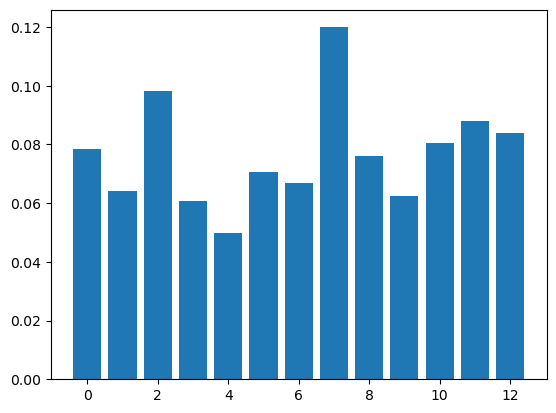

In [56]:
import matplotlib.pyplot as plt

yan = Yan()

state = yan.get_initial_state()
# state = yan.get_next_state(state, 2, 1)
# state = yan.get_next_state(state, 7, -1)

# print(state)

encoded_state = yan.get_encoded_state(state)

# print(encoded_state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)
model = BobNet().to(device)
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value, policy)

plt.bar(range(NUM_CLASSES), policy)
plt.show()


In [73]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        
        self.children = []
        
        self.visit_count = 0
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)
                
        return child
    
            
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.reward
        if self.parent is not None:
            self.parent.backpropagate(value)  


class MCTS:
    def __init__(self, game:Yan, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad() 
    def search(self, state):
        root = Node(self.game, self.args, state)
        
        for search in range(self.args['num_searches']):
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
                
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            
            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
                )   
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                # valid_moves = self.game.get_valid_moves(node.state)
                # valid_sized_move = valid_moves + np.zeros(13)
                # policy *= valid_sized_move
                # policy /= np.sum(policy)
                
                value = value.item()
                
                node.expand(policy)
                
            node.backpropagate(value)    
            
            
        action_probs = self.game.get_valid_moves(state)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
        
        
        

In [74]:
game = Yan()

args = {
    'C': 2,
    'num_searches': 100
}
model = BobNet()
model.eval()
mcts = MCTS(game, args, model)

state = game.get_initial_state()


while True:
    print(state)
    
    mcts_probs = mcts.search(state)
    action = np.argmax(mcts_probs)
        
    state = game.get_next_state(state, action)
    
    value, is_terminal = game.get_value_and_terminated(state, action)
    
    if is_terminal:
        print(game.desordem)
        print(game.get_total_score(state))
        game.reset()
        break
        
    # player = game.get_opponent(player)


[<Game_Moment.SECOS_1: 1>, 1, 3, 3, 3, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


IndexError: list index out of range